# Project: Investigating The European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

# <a id='intro'></a>
## Introduction

> In this project, I investigate the relationships between win percentage, goals scored, and goals against in professional European soccer. This analysis utilizes the [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) Kaggle dataset compiled by Hugo Mathien, which contains data on more than 25k matches,  10k players, and 259 teams in the European Soccer League between the years 2008 and 2016. 

> This analysis focuses on the following questions: 
    > - Which teams had the highest win percentage between the 2008/2009 and 2015/2016 seasons?
    > - Which teams had the most improvement by win percentage between the 2008/2009 and 2015/2016 seasons? 
    > - Which teams averaged the most goals scored per year? 
    > - Which leagues averaged the most goals scored between 2008/2009 and 2015/2016?
    > - Which teams had the most improvement in goals scored average between 2008/2009 and 2015/2016?
    > - How does goal differential compare with win percentage?

In [362]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> The data source (database.sqlite) was accessed through DB Browser for SQLite in order to perform inner joins, aggregations, and remove unnecessary columns using the below queries exported as combined_soccer_data.csv resulting in the following columns:
> * Team
> * Season
> * Country
> * League 
> * Goals Scored
> * Goals Against
> * Wins
> * Losses
> * Ties

``` mysql
-- SELECT relevant columns from Match, Country, League, and Teams tables
SELECT
      m.id,
      c.name AS country,
      l.name AS league,
      m.season,
      m.match_api_id,
      m.home_team_api_id,
      t1.team_long_name AS home_team,
      m.away_team_api_id,
      t2.team_long_name AS away_team,
      m.home_team_goal,
      m.away_team_goal,
      m.foulcommit,
      m.card
FROM match AS m
JOIN country AS c
ON m.country_id = c.id
JOIN league AS l
ON m.league_id = l.id
JOIN team AS t1
ON m.home_team_api_id = t1.team_api_id
JOIN team AS t2
ON m.away_team_api_id = t2.team_api_id
ORDER BY 4;

-- Create view of combined tables
CREATE VIEW combined AS SELECT
      m.id,
      c.name AS country,
      l.name AS league,
      m.season,
      m.match_api_id,
      m.home_team_api_id,
      t1.team_long_name AS home_team,
      m.away_team_api_id,
      t2.team_long_name AS away_team,
      m.home_team_goal,
      m.away_team_goal,
      m.foulcommit,
      m.card,
      CASE WHEN m.home_team_goal > m.away_team_goal THEN 1 ELSE 0
      END AS win_home,
      CASE WHEN m.home_team_goal < m.away_team_goal THEN 1 ELSE 0
      END AS win_away,
      CASE WHEN m.home_team_goal = m.away_team_goal THEN 1 ELSE 0
      END AS tie
FROM match AS m
JOIN country AS c
ON m.country_id = c.id
JOIN league AS l
ON m.league_id = l.id
JOIN team AS t1
ON m.home_team_api_id = t1.team_api_id
JOIN team AS t2
ON m.away_team_api_id = t2.team_api_id
ORDER BY 4;

-- Create Home Team records Table
SELECT
	  home_team AS team,
	  season,
      country,
      league,
      SUM(home_team_goal) AS goals_scored,
      SUM(away_team_goal) AS goals_against,
	  SUM(win_home) AS wins,
	  SUM(win_away) AS losses,
	  SUM(tie) AS ties
FROM combined
GROUP BY 1, 2
ORDER BY 2;

-- Create Away Team records Table
SELECT
      away_team AS team,
      season,
      SUM(away_team_goal) AS goals_scored,
      SUM(home_team_goal) AS goals_against,
      SUM(win_away) AS wins,
	  SUM(win_home) AS losses,
	  SUM(tie) AS ties
FROM combined
GROUP BY 1, 2
ORDER BY 2;

-- Create total wins/losses/ties/goals_scored/goals_against table
with t1 AS (
  SELECT
  		home_team AS team,
  		season,
        country,
        league,
        SUM(home_team_goal) AS goals_scored,
        SUM(away_team_goal) AS goals_against,
  		SUM(win_home) AS wins,
  		SUM(win_away) AS losses,
  		SUM(tie) AS ties
  FROM combined
  GROUP BY 1, 2
  ORDER BY 2
),

t2 AS (
  SELECT
        away_team AS team,
        season,
        SUM(away_team_goal) AS goals_scored,
        SUM(home_team_goal) AS goals_against,
        SUM(win_away) AS wins,
		SUM(win_home) AS losses,
		SUM(tie) AS ties
FROM combined
GROUP BY 1, 2
ORDER BY 2)

SELECT t1.team,
       t1.season,
       t1.country,
       t1.league,
       t1.goals_scored + t2.goals_scored AS goals_scored,
       t1.goals_against + t2.goals_against AS goals_against,
       t1.wins + t2.wins AS wins,
       t1.losses + t2.losses AS losses,
       t1.ties + t2.ties AS ties
FROM t1
JOIN t2
ON t1.team = t2.team AND t1.season = t2.season
ORDER BY 2, 1;
```

In [53]:
# Read in and preview the data file
df = pd.read_csv('combined_soccer_data.csv')
df.head()

,team,season,country,league,goals_scored,goals_against,wins,losses,ties
0,RSC Anderlecht,2008/2009,Belgium,Belgium Jupiler League,75,30,24,5,5
1,Standard de Liège,2008/2009,Belgium,Belgium Jupiler League,66,26,24,5,5
2,Club Brugge KV,2008/2009,Belgium,Belgium Jupiler League,59,50,18,11,5
3,KAA Gent,2008/2009,Belgium,Belgium Jupiler League,67,42,17,9,8
4,SV Zulte-Waregem,2008/2009,Belgium,Belgium Jupiler League,55,36,16,11,7


In [54]:
# inspect the data for any nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   team           1478 non-null   object
 1   season         1478 non-null   object
 2   country        1478 non-null   object
 3   league         1478 non-null   object
 4   goals_scored   1478 non-null   int64 
 5   goals_against  1478 non-null   int64 
 6   wins           1478 non-null   int64 
 7   losses         1478 non-null   int64 
 8   ties           1478 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 104.0+ KB


In [55]:
# View dataframe summary statistics 
df.describe()

,goals_scored,goals_against,wins,losses,ties
count,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000
mean,47.555480,47.555480,13.114344,13.114344,8.925575
std,15.895455,13.116502,5.566954,5.166010,2.934608
min,5.000000,1.000000,1.000000,0.000000,0.000000
25%,37.000000,39.000000,9.000000,10.000000,7.000000
50%,45.000000,48.000000,12.000000,13.000000,9.000000
75%,55.000000,56.000000,16.000000,17.000000,11.000000
max,121.000000,98.000000,33.000000,30.000000,21.000000


In [56]:
df['season'].value_counts()

2014/2015    188
2015/2016    188
2008/2009    187
2012/2013    186
2009/2010    185
2010/2011    185
2011/2012    185
2013/2014    174
Name: season, dtype: int64

In [17]:
df.groupby('league')['goals_scored'].sum().sort_values(ascending=False)

league
Spain LIGA BBVA             8412
England Premier League      8240
Italy Serie A               7895
Netherlands Eredivisie      7542
France Ligue 1              7427
Germany 1. Bundesliga       7103
Portugal Liga ZON Sagres    5201
Belgium Jupiler League      4841
Scotland Premier League     4804
Poland Ekstraklasa          4656
Switzerland Super League    4166
Name: goals_scored, dtype: int64

In [19]:
df.groupby('league')['team'].count().sort_values(ascending=False)

league
England Premier League      160
France Ligue 1              160
Italy Serie A               160
Spain LIGA BBVA             160
Germany 1. Bundesliga       144
Netherlands Eredivisie      144
Portugal Liga ZON Sagres    132
Poland Ekstraklasa          125
Belgium Jupiler League      117
Scotland Premier League      96
Switzerland Super League     80
Name: team, dtype: int64

### Data Cleaning

> Much of the data cleaning was achieved in the SQL query csv export. There are no nulls in the dataframe. All datatypes are consistent for processing. The following columns are created below in order to answer relevant questions:
> * Win Percentage (win_pct)
> * Goals Scored Average (gs_avg)
> * Goals Against Average (ga_avg)
> * Scoring Differential Average (score_diff_avg)
> * Overall Win Percentage (overall_win_pct)

> Win Percentage in the UEFA is calculated as (2 × Wins + Ties) / (2 × Total Games Played) × 100, with ties representing half the value of wins. 

> The following columns are renamed for brevity:
> * wins (W)
> * losses (L)
> * ties (T)

In [220]:
# Rename columns wins: W, losses: L, ties: T
df.rename(columns={"wins": "W", "losses": "L", "ties": "T"}, inplace=True)
df.head()

,team,season,country,league,goals_scored,goals_against,W,L,T,win_pct,overall_win_pct
0,RSC Anderlecht,2008/2009,Belgium,Belgium Jupiler League,75,30,24,5,5,0.705882,0.641657
1,Standard de Liège,2008/2009,Belgium,Belgium Jupiler League,66,26,24,5,5,0.705882,0.494718
2,Club Brugge KV,2008/2009,Belgium,Belgium Jupiler League,59,50,18,11,5,0.529412,0.581413
3,KAA Gent,2008/2009,Belgium,Belgium Jupiler League,67,42,17,9,8,0.500000,0.500000
4,SV Zulte-Waregem,2008/2009,Belgium,Belgium Jupiler League,55,36,16,11,7,0.470588,0.365866


In [229]:
# Calculate and Create Win Percentage (win_pct) column
df['win_pct'] = ((((df['W'] * 2) + df['T']) / ((df['W'] + df['L'] + df['T']) * 2)) * 100).round(2)
df.head()

,team,season,country,league,goals_scored,goals_against,W,L,T,win_pct,overall_win_pct
0,RSC Anderlecht,2008/2009,Belgium,Belgium Jupiler League,75,30,24,5,5,77.94,0.641657
1,Standard de Liège,2008/2009,Belgium,Belgium Jupiler League,66,26,24,5,5,77.94,0.494718
2,Club Brugge KV,2008/2009,Belgium,Belgium Jupiler League,59,50,18,11,5,60.29,0.581413
3,KAA Gent,2008/2009,Belgium,Belgium Jupiler League,67,42,17,9,8,61.76,0.500000
4,SV Zulte-Waregem,2008/2009,Belgium,Belgium Jupiler League,55,36,16,11,7,57.35,0.365866


In [231]:
# Calculate and Create Goals Scored Averge (gs_avg) column
# Calculate and Create Goals Against Average (ga_avg) column
# Calculate and Create Scoring Differential Average (score_diff_avg) column
df['gs_avg'] = (df['goals_scored'] / (df['W'] + df['L'] + df['T'])).round(2)
df['ga_avg'] = (df['goals_against'] / (df['W'] + df['L'] + df['T'])).round(2)
df['score_diff_avg'] = (df['gs_avg'] - df['ga_avg']).round(2)
df.head()

,team,season,country,league,goals_scored,goals_against,W,L,T,win_pct,overall_win_pct,gs_avg,ga_avg,score_diff_avg
0,RSC Anderlecht,2008/2009,Belgium,Belgium Jupiler League,75,30,24,5,5,77.94,0.641657,2.21,0.88,1.33
1,Standard de Liège,2008/2009,Belgium,Belgium Jupiler League,66,26,24,5,5,77.94,0.494718,1.94,0.76,1.18
2,Club Brugge KV,2008/2009,Belgium,Belgium Jupiler League,59,50,18,11,5,60.29,0.581413,1.74,1.47,0.27
3,KAA Gent,2008/2009,Belgium,Belgium Jupiler League,67,42,17,9,8,61.76,0.500000,1.97,1.24,0.73
4,SV Zulte-Waregem,2008/2009,Belgium,Belgium Jupiler League,55,36,16,11,7,57.35,0.365866,1.62,1.06,0.56


In [357]:
# Create and Calculate Overall Win Percentage (overall_win_pct) column
overall_win_pct = df.groupby('team').mean()['win_pct']
df['overall_win_pct'] = df.team.map(overall_win_pct).round(2)
df.head()

,team,season,country,league,goals_scored,goals_against,W,L,T,win_pct,overall_win_pct,gs_avg,ga_avg,score_diff_avg
0,RSC Anderlecht,2008/2009,Belgium,Belgium Jupiler League,75,30,24,5,5,77.94,75.74,2.21,0.88,1.33
1,Standard de Liège,2008/2009,Belgium,Belgium Jupiler League,66,26,24,5,5,77.94,59.49,1.94,0.76,1.18
2,Club Brugge KV,2008/2009,Belgium,Belgium Jupiler League,59,50,18,11,5,60.29,67.63,1.74,1.47,0.27
3,KAA Gent,2008/2009,Belgium,Belgium Jupiler League,67,42,17,9,8,61.76,62.20,1.97,1.24,0.73
4,SV Zulte-Waregem,2008/2009,Belgium,Belgium Jupiler League,55,36,16,11,7,57.35,51.34,1.62,1.06,0.56


<a id='eda'></a>
## Exploratory Data Analysis

### Which teams had the highest win percentage between the 2008/2009 and 2015/2016 seasons? 

In [358]:
# Create a function to calculate single column groupby's sorted in descending order
def group_sort(column, value):
    '''takes a dataframe column and value and performs a groupby mean calculation
    sorted in descending order'''
    return df.groupby(column)[value].mean().sort_values(ascending=False)

group_sort('team','overall_win_pct').head(10)

team
FC Barcelona        84.04
FC Porto            82.38
SL Benfica          81.72
Real Madrid CF      80.92
Celtic              79.93
Rangers             79.28
FC Bayern Munich    79.05
Ajax                77.39
RSC Anderlecht      75.74
FC Basel            74.14
Name: overall_win_pct, dtype: float64

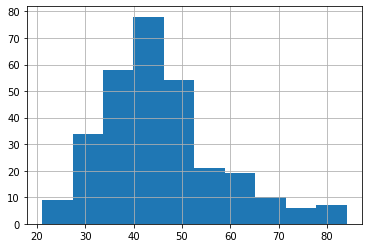

In [234]:
# Plot the distribution of Overall Win Percentages
overall_win_pct.hist();

It appears that most team overall win percentages are below 50%, let's take a closer look

In [237]:
overall_win_pct.describe()

count    296.000000
mean      45.366659
std       12.215030
min       21.050000
25%       36.736667
50%       43.216190
75%       51.222500
max       84.045000
Name: win_pct, dtype: float64

Of 296 teams, the mean overall win percentage is 45.36. The median overall win percentage is 43.21. 75% of teams have overall win percentages of 51.22 or below. 

Which teams had the highest *single season* win percentages between 2008 and 2016?

In [251]:
df[['team', 'season', 'win_pct']].sort_values(by=['win_pct'],ascending=False).head(10)

,team,season,win_pct
1042,FC Porto,2010/2011,95.00
509,FC Bayern Munich,2012/2013,91.18
681,Juventus,2013/2014,90.79
1074,FC Porto,2012/2013,90.00
527,FC Bayern Munich,2013/2014,89.71
1258,FC Barcelona,2009/2010,89.47
1298,Real Madrid CF,2011/2012,89.47
1318,FC Barcelona,2012/2013,89.47
1202,Celtic,2013/2014,89.47
1075,SL Benfica,2012/2013,88.33


The highest single season win percentage belongs to FC Portoat 95%, achieved during the 2010/2011 season. 

Let's see how the single season win percentage distribution looks compared to the overall win percentages.

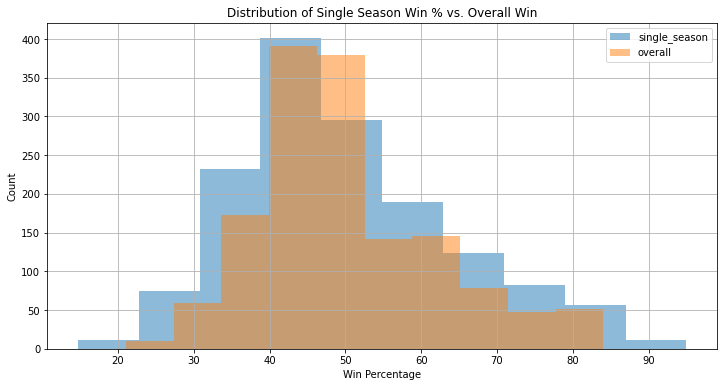

In [366]:
plt.figure(figsize=(12,6))
df['win_pct'].hist(alpha=0.5, label='single_season')
df['overall_win_pct'].hist(alpha=0.5, label='overall')
plt.legend()
plt.xlabel('Win Percentage')
plt.ylabel('Count')
plt.title('Distribution of Single Season Win % vs. Overall Win');

In [380]:
print("Single Season Win %:")
print(df.win_pct.describe())
print("")
print("Overall Win %:") 
print(df.overall_win_pct.describe())

Single Season Win %:
count    1478.000000
mean       50.017794
std        14.215064
min        14.710000
25%        40.000000
50%        47.260000
75%        58.902500
max        95.000000
Name: win_pct, dtype: float64

Overall Win %:
count    1478.000000
mean       50.017544
std        11.981071
min        21.050000
25%        42.100000
50%        47.610000
75%        56.410000
max        84.040000
Name: overall_win_pct, dtype: float64


We see here that the distributions are very similar, with a slightly higher concentration of overall percentages within the 40-52% range and slightly higher and lower outliers in the single season percentages, as would be expected.

### Which teams had the most improvement by win percentage between 2008/2009 and 2015/2016?

In [275]:
# Create separate dataframes for 2008/2009 and 2015/2016 seasons
df_0809 = df[df['season'] == '2008/2009']
df_1516 = df[df['season'] == '2015/2016']

# Drop unnecessary columns from the dataframes
cols = ['season', 'country', 'W', 'L', 'T', 'overall_win_pct']
df_0809.drop(cols, axis=1, inplace=True)
df_1516.drop(cols, axis=1, inplace=True)

# Combine the dataframes
df_cmb = df_0809.merge(df_1516, on='team', suffixes=('_0809', '_1516'))

# Create a Win Percentage difference dataframe
df_cmb['diff'] = df_cmb['win_pct_1516'] - df_cmb['win_pct_0809']
df_cmb_sorted = df_cmb.sort_values('diff', ascending=False)
df_cmb_sorted[['team', 'win_pct_1516', 'win_pct_0809','diff']].head(10)

,team,win_pct_1516,win_pct_0809,diff
62,Napoli,75.00,44.74,30.26
89,Piast Gliwice,68.33,40.00,28.33
28,Paris Saint-Germain,86.84,59.21,27.63
50,Borussia Mönchengladbach,55.88,33.82,22.06
39,FC Bayern Munich,88.24,69.12,19.12
19,Tottenham Hotspur,67.11,48.68,18.43
33,AS Monaco,63.16,44.74,18.42
129,FC Luzern,54.17,36.11,18.06
80,Heracles Almelo,54.41,36.76,17.65
70,PSV,85.29,67.65,17.64


Napoli had the highest overall improvement in win percentage, improving from 44.7% to 75%

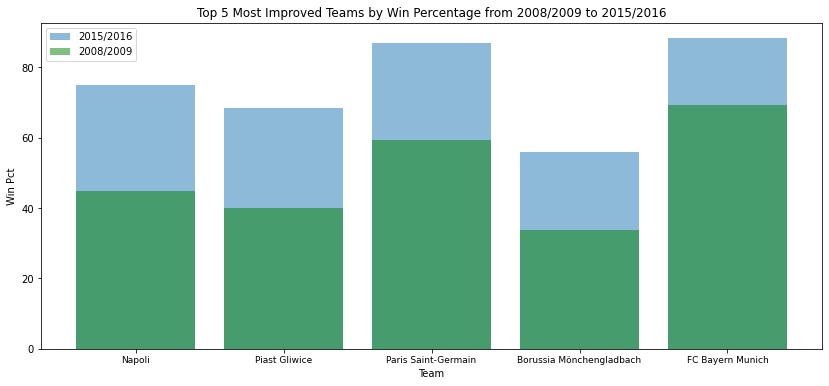

In [353]:
df_cmb_plot = df_cmb_sorted[['team', 'win_pct_1516', 'win_pct_0809','diff']].head(5)
plt.figure(figsize=(14,6))
plt.bar(df_cmb_plot['team'], df_cmb_plot['win_pct_1516'], alpha=0.5, label='2015/2016')
plt.bar(df_cmb_plot['team'], df_cmb_plot['win_pct_0809'], alpha=0.5, label='2008/2009', color ='green')
plt.xlabel('Team')
plt.ylabel('Win Pct')
plt.xticks(fontsize=9)
plt.legend()
plt.title('Top 5 Most Improved Teams by Win Percentage from 2008/2009 to 2015/2016');

From the above chart, we can see that Napoli and Piast Gliwice had the largest improvements, while Paris Saint-Germain and FC Bayern Munich had the highest win percentages amongst the most improved teams.

### Which teams averaged the most goals scored per year?

In [359]:
group_sort('team', 'gs_avg').head(10)

team
FC Barcelona        2.79250
Real Madrid CF      2.77125
FC Bayern Munich    2.39875
PSV                 2.39750
Ajax                2.38000
Celtic              2.28625
SL Benfica          2.28125
FC Porto            2.18375
FC Basel            2.16250
Rangers             2.13500
Name: gs_avg, dtype: float64

In [313]:
### Which teams averaged the fewest goals scored per year? 

In [360]:
group_sort('team', 'gs_avg').sort_values().head(10)

team
AC Arles-Avignon        0.550
Córdoba CF              0.580
Pescara                 0.710
FC Dordrecht            0.710
Grenoble Foot 38        0.725
Middlesbrough           0.740
Boavista FC             0.750
SpVgg Greuther Fürth    0.760
Uniao da Madeira        0.790
Reggio Calabria         0.790
Name: gs_avg, dtype: float64

Let's take a look at how scoring differential relates to win percentage.

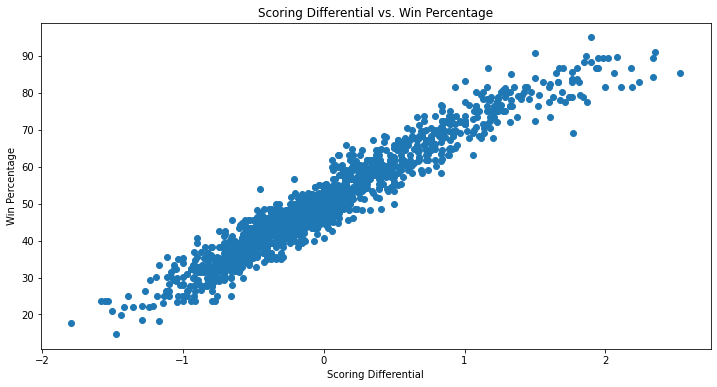

In [321]:
score_diff = df['score_diff_avg']
win_pct = df['win_pct']

plt.figure(figsize=(12,6))
plt.scatter(score_diff, win_pct)
plt.xlabel('Scoring Differential')
plt.ylabel('Win Percentage')
plt.title('Scoring Differential vs. Win Percentage')
plt.show();

There is a clear positive correlation between scoring differential and win percentage. Teams with an average scoring differential of 1 or greater had a win percentage of at least 65%. Converseley, teams with a negative scoring differential of -1 or less had a win percentage of no higher than 35%. 

### Which leagues averaged the most goals scored between 2008/2009 and 2015/2016?

In [361]:
group_sort('league','gs_avg')

league
Netherlands Eredivisie      1.540625
Switzerland Super League    1.462250
Germany 1. Bundesliga       1.450486
Belgium Jupiler League      1.396325
Spain LIGA BBVA             1.383250
England Premier League      1.355125
Scotland Premier League     1.317187
Italy Serie A               1.307438
Portugal Liga ZON Sagres    1.265985
France Ligue 1              1.221437
Poland Ekstraklasa          1.219680
Name: gs_avg, dtype: float64

If you wanted to see a high scoring game between 2008/2009 and 2015/2016, your best bet was to see a Netherlands Eredivisie match!

### Which teams had the most improvement in goals scored average between 2008/2009 & 2015/2016?

In [345]:
gs_avg_0809 = df[df['season'] == '2008/2009']
gs_avg_1516 = df[df['season'] == '2015/2016']

cols =  ['season', 'country', 'league', 'goals_scored', 'goals_against', 'W', 'L', 'T', 'win_pct', 'overall_win_pct', 'ga_avg', 'score_diff_avg']

gs_avg_0809.drop(columns = cols, inplace=True)
gs_avg_1516.drop(columns = cols, inplace=True)

/Users/joshiden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [351]:
gs_avg_diff = gs_avg_0809.merge(gs_avg_1516, on='team', suffixes=('_0809', '_1516'))
gs_avg_diff['diff'] = gs_avg_diff['gs_avg_1516'] - gs_avg_diff['gs_avg_0809']
gs_avg_diff.groupby('team')['diff'].mean().sort_values(ascending=False).head()

team
Paris Saint-Germain         1.39
Cracovia                    1.10
Piast Gliwice               1.06
Napoli                      0.98
Borussia Mönchengladbach    0.82
Name: diff, dtype: float64

The most improved teams in goals scored per game from 2008/2009 to 2015/2016 were Paris Saint-Germain, Cracovia, Piaste Gliwice, Napoli, and Borussia Monchengladbach.

<a id='conclusions'></a>
## Conclusions

###  1. Which teams had the highest win percentage between the 2008/2009 and 2015/2016 seasons?

> 1. FC Barcelona        84.04
> 2. FC Porto            82.38
> 3. SL Benfica          81.72
> 4. Real Madrid CF      80.92
> 5. Celtic              79.93

### 2. Which teams had the most improvement by win percentage between the 2008/2009 and 2015/2016 seasons?

> 1. Napoli +30.26
> 2. Piast Gliwice +28.33
> 3. Paris Saint-Germain +27.63
> 4. Borussia Mönchengladbach +22.06
> 5. FC Bayern Munich +19.12

### 3. Which teams averaged the most goals scored per year? 

> 1. FC Barcelona        2.79250
> 2. Real Madrid CF      2.77125
> 3. FC Bayern Munich    2.39875
> 4. PSV                 2.39750
> 5. Ajax                2.38000

### 4. Which leagues averaged the most goals scored between 2008/2009 and 2015/2016?

> 1. Netherlands Eredivisie      1.540625
> 2. Switzerland Super League    1.462250
> 3. Germany 1. Bundesliga       1.450486
> 4. Belgium Jupiler League      1.396325
> 5. Spain LIGA BBVA             1.383250

### 5. Which teams had the most improvement in goals scored average between 2008/2009 and 2015/2016?

> 1. Paris Saint-Germain         1.39
> 2. Cracovia                    1.10
> 3. Piast Gliwice               1.06
> 4. Napoli                      0.98
> 5. Borussia Mönchengladbach    0.82

### 6. How does goal difference compare with win percentage?

There is a clear positive correlation between scoring differential and win percentage. Teams with an average scoring differential of 1 or greater had a win percentage of at least 65%. Converseley, teams with a negative scoring differential of -1 or less had a win percentage of no higher than 35%.

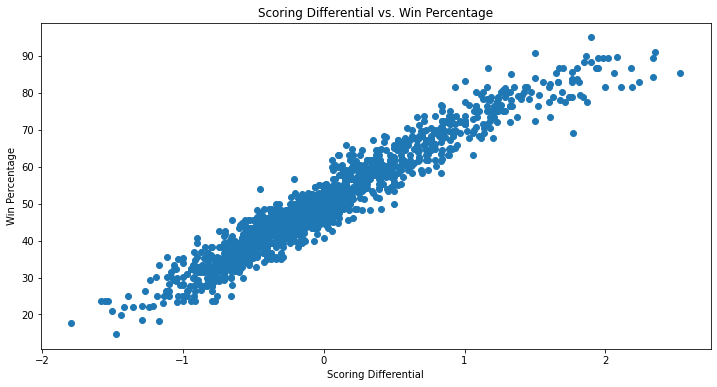

In [352]:
plt.figure(figsize=(12,6))
plt.scatter(score_diff, win_pct)
plt.xlabel('Scoring Differential')
plt.ylabel('Win Percentage')
plt.title('Scoring Differential vs. Win Percentage')
plt.show();

### Analysis Shortcomings & Data Limitations

The dataset contains information on 11 leagues and 296 teams over 8 seasons. Additional useful information would include comparisons across other 8 season time periods. The league [UEFA coefficient](https://en.wikipedia.org/wiki/UEFA_coefficient) would be another useful metric for observing team ranking within each league. 

One of the shortcomings of this analysis is that it does not observe the fluctuation of single season metrics over the course of the 8 year period. Further analysis could display visuals communicating the year-by-year fluctuation across teams and leagues in goals scored averages and win percentage. 

### References

> * Stack Overflow
> * Pandas.pydata.org
> * Matplotlibe.org